In [7]:
import sys
import os
import warnings
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import google.generativeai as genai
from dotenv import load_dotenv

if str(Path().resolve().parent) not in sys.path:
    sys.path.append(str(Path().resolve().parent))

load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

warnings.filterwarnings("ignore", category=FutureWarning)

from src.config import PREPROCESSED_BLOG_DATASET_PATH
from src.text_extraction import *
from src.models_setup import embedding_model, gemini_2_flash
from src.prompts import prompt_rag, prompt_zero_cot, prompt_retry_with_memory_usage
from src.output_formats import BlogGeneration, BlogClassificationCoT
from src.helpers import get_examples, load_or_create_vector_store
from src.blog_generator import BlogGenerator
from src.long_term_memory import LongTermMemory

# Data Processing

In [2]:
# Import data
blogs = pd.read_csv(PREPROCESSED_BLOG_DATASET_PATH)

# Generator manual test

In [32]:
vector_store = load_or_create_vector_store()

def find_most_similar_article(query_text):
    query_embedding = embedding_model.encode(query_text, clean_up_tokenization_spaces=True)
    results = vector_store.similarity_search_by_vector(query_embedding, k=2)

    if results:
        most_similar = results[1]
        return most_similar.page_content, most_similar.metadata

Loading vector store from: /home/kanstantsin-downar/PycharmProjects/bachalor-project/llm_blog_generator/data/vector_store
Vector store loaded successfully.


In [33]:
paper_text = extract_paper_text(blogs.loc[0, "url_paper"])
example_paper, example_blog_metadata = find_most_similar_article(paper_text)
example_blog = example_blog_metadata["blog_full_text"]

In [34]:
# RAG approach
llm_generator = gemini_2_flash.with_structured_output(BlogGeneration, include_raw=True)
generation_chain = prompt_rag | llm_generator
#print(prompt_rag.format(paper_text=paper_text,
#                        example_paper=example_paper,
#                        example_blog=example_blog))

In [40]:
generator_response = generation_chain.invoke({"paper_text": paper_text,
                                              "example_paper": example_paper,
                                              "example_blog": example_blog})

In [41]:
print(generator_response["parsed"].text)

# Level Up Your Language Model with Self-Generated Critiques

By Yue Yu, Zhengxing Chen, Aston Zhang, Liang Tan, Chenguang Zhu, Richard Yuanzhe Pang, Yundi Qian, Xuewei Wang, Suchin Gururangan, Chao Zhang, Melanie Kambadur, Dhruv Mahajan, Rui Hou

## Introduction

Imagine your language model constantly learning and improving, not just from external data, but from its own insightful self-critiques. That's the power of **Critic-RM**, a new framework that boosts reward modeling for language models using self-generated critiques. This innovative approach enhances language models' ability to align with human preferences, leading to more helpful, honest, and harmless responses.

Reward modeling is crucial for aligning large language models (LLMs) with human preferences, especially in reinforcement learning from human feedback (RLHF). However, current reward models mainly produce unexplainable scalar scores and struggle to incorporate critiques in a natural language format. We hypothesize tha

In [42]:
examples = get_examples()
blog_text = generator_response["parsed"].text

llm_evaluator = gemini_2_flash.with_structured_output(BlogClassificationCoT, include_raw=True)
evaluation_chain = prompt_zero_cot | llm_evaluator
print(prompt_zero_cot.format(a="test for redundant additional parameters" ,blog_text=blog_text))

You are a very strict expert in evaluating written content, specializing in assessing how well blogs communicate scientific research to a broader audience.

Task:
Analyze the engagement level of the blog below based on the following criteria:
    - Readability
    - Structure
    - Informativeness
    - Attractiveness of the blog title
    - Clarity
    - Audience appeal
    - Potential for discussion
        
Clarifications:
    - Focus only on the textual content of the blog, disregarding any visual or interactive elements. This means that there is no need to add points related to the addition of illustrations or interactive elements to possible improvements.
    - Calmly lower your blog assessment according to the number of bugs.
    - Return ONLY a valid JSON object in plain text.

Expected Output Format:
    - Step by step, explain your analysis for each of the criteria listed above. Start by evaluating readability, then move on to structure, informativeness, and so on. Make sure 

In [43]:
evaluator_response = evaluation_chain.invoke({**examples, "blog_text": blog_text})

In [44]:
print(f"Overall assessment: {evaluator_response["parsed"].overall_assessment}")

Overall assessment: Good


In [63]:
improvements = evaluator_response["parsed"].improvements
print(f"Possible improvements:")
for i, improvement in enumerate(improvements):
    print(f"{i+1}. {improvement}")

Possible improvements:
1. Add more specific implementation details or technical aspects to increase informativeness.
2. Define all technical AI/ML terms for better readability for a broader audience. 


In [64]:
possible_improvements = "\n".join([f"{i+1}. {improvement}" for i, improvement in enumerate(improvements)])
memory = LongTermMemory()
blog = generator_response["parsed"].text
similar_blog, metadata = memory.retrieve_memory(blog)

# Reflexion
generation_chain = prompt_retry_with_memory_usage | llm_generator

Loading long term memory module from: /home/kanstantsin-downar/PycharmProjects/bachalor-project/llm_blog_generator/data/long_term_memory
Long term memory module loaded successfully.
Found relevant memory.


In [65]:
generator_response = generation_chain.invoke({
    "generated_blog": blog,
    "possible_improvements": possible_improvements,
    "similar_blog": similar_blog,
    "similar_blog_score":
        metadata["overall_assessment"],
    "similar_blog_improvements":
        metadata["improvements"]
})

In [66]:
print(generator_response["parsed"].text)

# Level Up Your Language Model with Self-Generated Critiques

By Yue Yu, Zhengxing Chen, Aston Zhang, Liang Tan, Chenguang Zhu, Richard Yuanzhe Pang, Yundi Qian, Xuewei Wang, Suchin Gururangan, Chao Zhang, Melanie Kambadur, Dhruv Mahajan, Rui Hou

## Introduction

Imagine a world where AI can not only generate text but also critique and improve its own work. That's the core idea behind **Critic-RM**, a novel approach that enhances language models by enabling them to learn from self-generated critiques. This leads to AI that better understands and aligns with what humans want, ultimately creating more helpful, honest, and harmless interactions. Think of a customer service chatbot that doesn't just answer your questions, but also identifies and corrects any misleading or unhelpful information in its response, ensuring a truly satisfying experience. This is especially useful when using Reinforcement Learning from Human Feedback (RLHF), a process where a model learns from feedback to bette

In [67]:
blog_text = generator_response["parsed"].text
evaluator_response = evaluation_chain.invoke({**examples, "blog_text": blog_text})

In [68]:
print(f"Overall assessment: {evaluator_response["parsed"].overall_assessment}")

Overall assessment: Very Good


# End-to-end generation test

In [69]:
generator = BlogGenerator(use_memory=True, use_reflexion=True)

Loading vector store from: /home/kanstantsin-downar/PycharmProjects/bachalor-project/llm_blog_generator/data/vector_store
Vector store loaded successfully.
Loading long term memory module from: /home/kanstantsin-downar/PycharmProjects/bachalor-project/llm_blog_generator/data/long_term_memory
Long term memory module loaded successfully.
BlogGenerator initialized with vector store.


In [70]:
blog = generator.generate_blog(blogs.loc[0, "url_paper"])

----------
Extracting paper text from URL: https://arxiv.org/pdf/2411.16646
Found most similar article.
Attempt number 1: Generating blog...
Using RAG prompt...
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 1, RPM: 1, TPM: 36169
Blog generated successfully.
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 2, RPM: 2, TPM: 37996
Blog evaluated successfully. Evaluation: Good.
Found 2 similar blogs. Upsert blog to memory...
Deleting blogs with ids: ['c52bfd62-5395-4ca7-90fb-b18a11b5061b']
Blog generation attempt 1 unsuccessful. Retrying...
Attempt number 2: Generating blog...
Using retry prompt with Reflexion and memory module...
Found relevant memory.
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 3, RPM: 3, TPM: 42556
Blog generated successfully.
Checking req

In [71]:
print(blog)

# Self-Improving Language Models: How Synthetic Critiques Boost Reward Modeling

By Yue Yu, Zhengxing Chen, Aston Zhang, Liang Tan, Chenguang Zhu, Richard Yuanzhe Pang, Yundi Qian, Xuewei Wang, Suchin Gururangan, Chao Zhang, Melanie Kambadur, Dhruv Mahajan, and Rui Hou

Imagine teaching a computer to not only generate text but also to critique its own work. That's the core idea behind our new research, which focuses on improving how we align large language models (LLMs) with human preferences. We introduce Critic-RM, a framework that uses self-generated critiques to train reward models. This leads to notable improvements in how well these models understand and rank preferences, as well as in their reasoning abilities.

## The Challenge of Reward Modeling: Why It Matters

Reward models are crucial for something called reinforcement learning from human feedback (RLHF). Think of RLHF as a way to guide LLMs—like the ones powering chatbots—to produce helpful, honest, and harmless responses.

# Experiments

In [3]:
MAX_ATTEMPTS = 5
generator = BlogGenerator()

Loading vector store from: /home/kanstantsin-downar/PycharmProjects/bachalor-project/llm_blog_generator/data/vector_store
Vector store loaded successfully.
Loading long term memory module from: /home/kanstantsin-downar/PycharmProjects/bachalor-project/llm_blog_generator/data/long_term_memory
Failed to load Long term memory module. Initializing a new one...
Long term memory module initialized successfully with dummy data.
BlogGenerator initialized with vector store.


## RAG only approach

In [4]:
generator.max_attempts = MAX_ATTEMPTS
generator.experiment_mode = True
generator.use_memory = False
generator.use_reflexion = False

In [5]:
assessment_history_only_RAG = []
best_assessment_history_only_RAG = []
redo_only_RAG = []
for index, row in blogs.iterrows():
    assessment, best_assessment = generator.generate_blog(paper_url=row["url_paper"])
    if assessment and best_assessment:
        assessment_history_only_RAG.append(assessment)
        best_assessment_history_only_RAG.append(best_assessment)
    else:
        redo_only_RAG.append(index, len(assessment_history_only_RAG))
        assessment_history_only_RAG.append([-1 for _ in range(MAX_ATTEMPTS)])
        best_assessment_history_only_RAG.append([-1 for _ in range(MAX_ATTEMPTS)])

----------
Extracting paper text from URL: https://arxiv.org/pdf/2411.16646
Found most similar article.
Attempt number 1: Generating blog...
Using RAG prompt...
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 1, RPM: 1, TPM: 36327
Blog generated successfully.
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 2, RPM: 2, TPM: 38211
Blog evaluated successfully. Evaluation: Good.
No similar blogs found, new blog is added to memory.
Attempt number 2: Generating blog...
Using RAG prompt...
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 3, RPM: 3, TPM: 74639
Blog generated successfully.
Checking request limits before invoking the model...
Invoking the model...
Model invoked successfully. Total requests today: 4, RPM: 4, TPM: 76466
Blog evaluated successfully. Evaluat

In [6]:
print(redo_only_RAG)

[]


## Reflexion

In [ ]:
generator.use_reflexion = True

In [ ]:
assessment_history = []
best_assessment_history = []
redo = []
for index, row in blogs.iterrows():
    assessment, best_assessment = generator.generate_blog(paper_url=row["url_paper"])
    if assessment and best_assessment:
        assessment_history.append(assessment)
        best_assessment_history.append(best_assessment)
    else:
        redo.append(index, len(assessment_history))
        assessment_history.append([-1 for _ in range(MAX_ATTEMPTS)])
        best_assessment_history.append([-1 for _ in range(MAX_ATTEMPTS)])

In [ ]:
print(redo)

## Reflexion + Long Term Memory

In [ ]:
generator.use_memory = True

In [ ]:
assessment_history_with_memory_usage = []
best_assessment_history_with_memory_usage = []
redo_with_memory_usage = []
for index, row in blogs.iterrows():
    assessment, best_assessment = generator.generate_blog(paper_url=row["url_paper"])
    if assessment and best_assessment:
        assessment_history_with_memory_usage.append(assessment)
        best_assessment_history_with_memory_usage.append(best_assessment)
    else:
        redo.append(index, len(assessment_history_with_memory_usage))
        assessment_history_with_memory_usage.append([-1 for _ in range(MAX_ATTEMPTS)])
        best_assessment_history_with_memory_usage.append([-1 for _ in range(MAX_ATTEMPTS)])

In [ ]:
print(redo_with_memory_usage)

# Results

In [7]:
assessment_history_only_RAG = np.array(assessment_history_only_RAG)
average_assessment_only_RAG = np.mean(assessment_history_only_RAG, axis=0)

best_assessment_history_only_RAG = np.array(best_assessment_history_only_RAG)
average_best_assessment_only_RAG = np.mean(best_assessment_history_only_RAG, axis=0)

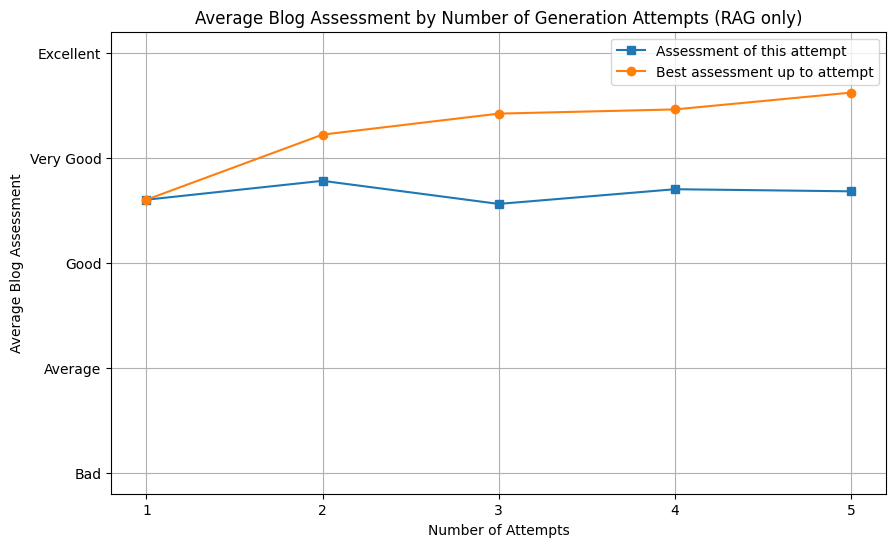

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), average_assessment_only_RAG, marker="s", label="Assessment of this attempt")
plt.plot(range(1, 6), average_best_assessment_only_RAG, marker="o", label="Best assessment up to attempt")

distance_from_edge = 0.2
plt.ylim(1 - distance_from_edge, 5 + distance_from_edge)
plt.yticks([1, 2, 3, 4, 5], ["Bad", "Average", "Good", "Very Good", "Excellent"])
plt.xticks(range(1, 6))

plt.xlabel("Number of Attempts")
plt.ylabel("Average Blog Assessment")
plt.title("Average Blog Assessment by Number of Generation Attempts (RAG only)")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
assessment_history = np.array(assessment_history)
average_assessment = np.mean(assessment_history, axis=0)

best_assessment_history = np.array(best_assessment_history)
average_best_assessment = np.mean(best_assessment_history, axis=0)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), average_assessment, marker="s", label="Assessment of this attempt")
plt.plot(range(1, 6), average_best_assessment, marker="o", label="Best assessment up to attempt")

distance_from_edge = 0.2
plt.ylim(1 - distance_from_edge, 5 + distance_from_edge)
plt.yticks([1, 2, 3, 4, 5], ["Bad", "Average", "Good", "Very Good", "Excellent"])
plt.xticks(range(1, 6))

plt.xlabel("Number of Attempts")
plt.ylabel("Average Blog Assessment")
plt.title("Average Blog Assessment by Number of Generation Attempts (Reflexion)")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
assessment_history_with_memory_usage = np.array(assessment_history_with_memory_usage)
average_assessment_with_memory_usage = np.mean(assessment_history_with_memory_usage, axis=0)

best_assessment_history_with_memory_usage = np.array(best_assessment_history_with_memory_usage)
average_best_assessment_with_memory_usage = np.mean(best_assessment_history_with_memory_usage, axis=0)

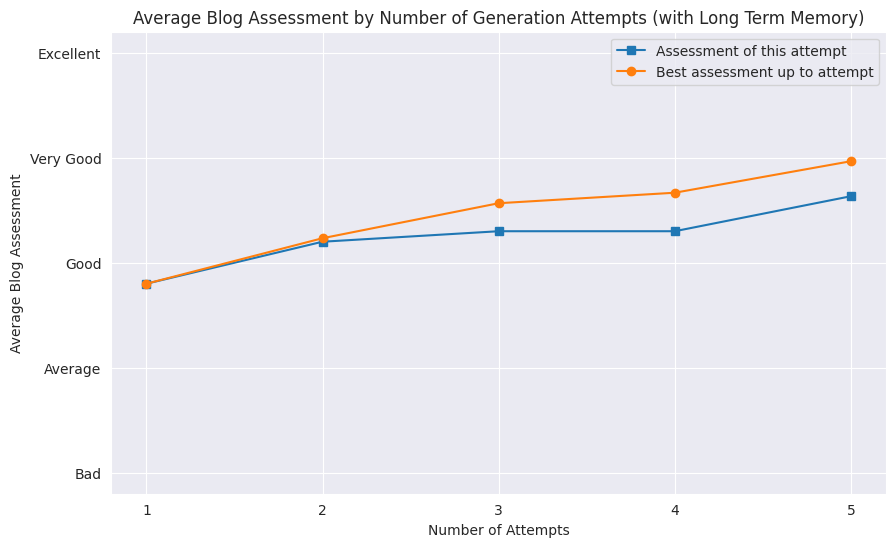

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), average_assessment_with_memory_usage, marker="s", label="Assessment of this attempt")
plt.plot(range(1, 6), average_best_assessment_with_memory_usage, marker="o", label="Best assessment up to attempt")

distance_from_edge = 0.2
plt.ylim(1 - distance_from_edge, 5 + distance_from_edge)
plt.yticks([1, 2, 3, 4, 5], ["Bad", "Average", "Good", "Very Good", "Excellent"])
plt.xticks(range(1, 6))

plt.xlabel("Number of Attempts")
plt.ylabel("Average Blog Assessment")
plt.title("Average Blog Assessment by Number of Generation Attempts (Reflexion + Long Term Memory as vector storage)")
plt.legend()
plt.grid(True)

plt.show()